# Multi-class Dog Breed Classification

This notebook builds an end-to-end multi-class image classifier using deep learning.

## 1. Problem 

Identify the breed of a dog given an image of a dog.

## 2. Data

The data we are using is from Kaggle's dog breed identification.

https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation

Submissions are evaluated on Multi Class Log Loss between the predicted probability and the observed target.

For each image in the test set, you must predict a probability for each of the different breeds. The file should contain a header and have the following format:

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

## 4. Features

Some information about the data:

* We are dealing with images (unstructured data). Best to use deep learning/transfer learning.
* There are 120 breeds of dogs (120 different classes).
* There are around 10,000+ images in the training set (with labels).
* There are around 10,000+ images in the test set (no labels).


### Get our workspace ready

* Import TensorFlow 2.x
* Import TensorFlow Hub
* Make sure we are using a GPU

In [1]:
# Import TensorFlow into Colab
# Import TensorFlow Hub into Colab
import tensorflow as tf
import tensorflow_hub as hub
print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)

# Check for GPU availability
print("GPU", "available (YES)" if tf.config.list_physical_devices("GPU") else "not available (NO)")

TF version: 2.4.1
TF Hub version: 0.12.0
GPU available (YES)


## Getting our data ready (turning into Tensors)




In [2]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("/content/drive/MyDrive/Dog Breed Identification/labels.csv")

In [3]:
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     f66c888ffa1ff06fcc2eddafb3e13aaf  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


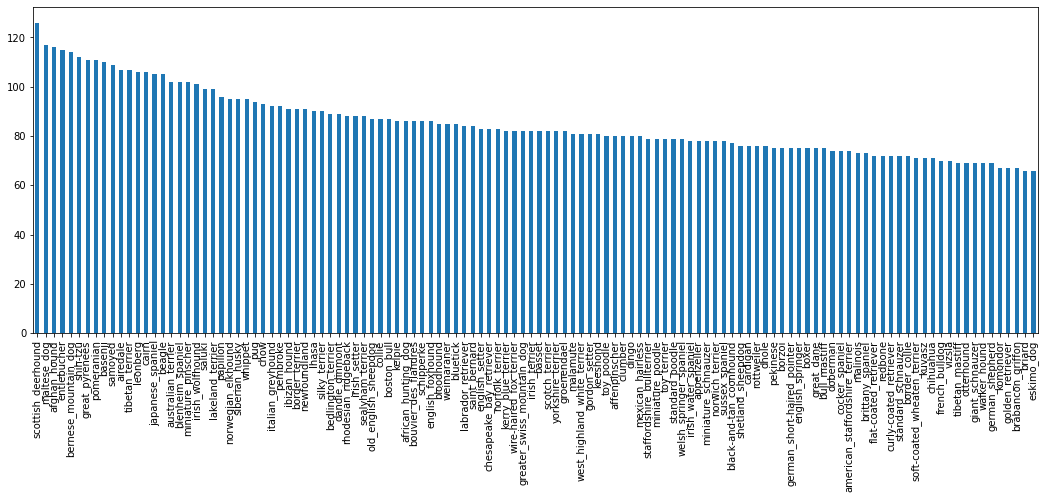

In [4]:
# How many images are there of each breed?
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 6))
labels_csv["breed"].value_counts().plot(kind="bar");

In [5]:
# Average number of images per dog breed
labels_csv["breed"].value_counts().mean()

85.18333333333334

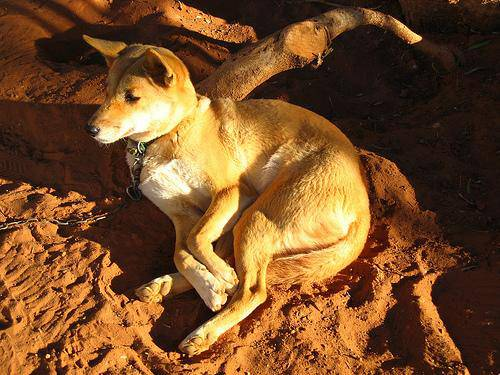

In [6]:
# Let's view an image
from IPython.display import Image
Image("drive/MyDrive/Dog Breed Identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

### Getting images and their labels

In [7]:
# Create pathnames from images ID's
filenames = ["drive/MyDrive/Dog Breed Identification/train/" + fname + ".jpg" for fname in labels_csv["id"]]

# View first 10
filenames[:10]

['drive/MyDrive/Dog Breed Identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog Breed Identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dog Breed Identification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dog Breed Identification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dog Breed Identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Dog Breed Identification/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Dog Breed Identification/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Dog Breed Identification/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Dog Breed Identification/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Dog Breed Identification/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [8]:
# Check wheteher number of filenames matches number of actual image files
import os
if len(os.listdir("drive/MyDrive/Dog Breed Identification/train")) == len(filenames):
  print("Filenames match actual amount of files. Proceed.")
else:
  print("Filenames do not match actual amount of files, check the target directory.")

Filenames match actual amount of files. Proceed.


Let's prepare our labels.

In [9]:
import numpy as np
labels = np.array(labels_csv["breed"])
len(labels)

10222

In [10]:
# Check if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames.")
else:
  print("Number of labels does not match number of filenames. Check data directories")

Number of labels matches number of filenames.


In [11]:
# Find the unique label values
unique_breed = np.unique(labels)
len(unique_breed)

120

In [12]:
# Trun every label into boolean array
boolean_labels = [label == unique_breed for label in labels]
len(boolean_labels)

10222

In [13]:
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [14]:
# Turning boolean array into integers EXAMPLE
print(labels[0]) # original label
print(np.where(unique_breed == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Create Validation set

Since the dataset from Kaggle doesn't come with a validation set, we create our own.

In [15]:
# Setup X & y variables
X = filenames
y = boolean_labels

We are going to start with ~1000 images and increase as needed.

In [16]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [17]:
# Let's split data into train and validation sets
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES], 
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

## Preprocessing Images (turning images into Tensors)

to preprocess images into Tensors we create a function that does:
1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn our `image` (jpg) into Tensors
4. Normalize our `image` (convert color channel values from 0-255 to 0-1)
5. Resize th `image` to be a shape of (224, 224)
6. Return the modified `image`

In [18]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size = IMG_SIZE):
  '''
  Takes an image file path and a value,  turns the image into a tensor of size of that value
  '''
  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 color channel (RGB)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the color channel values to from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired values
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

## Turning our data into batches

We process 32 images at a time (batch_size = 32)

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this: (`image`, `label`)

In [19]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  '''
  Takes an image file path name and the associated label, preocess the image and returns a tuple of (image, label).
  '''
  image = process_image(image_path)
  return image, label

Now we have a way to turn our data into tuples of Tensors in the form: (`image`,`label`), let's make a function to turn all our data (`X` & `y`) into batches.

In [20]:
# Define batch size at 32
BATCH_SIZE = 32

# Create a funciton to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  '''
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffle the data if it's training data but doesn't shiffle if it's validation data.
  Also accepts test data as input (no labels).
  '''
  # If test data, we dont have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  
  # if the data is a valid dataset, no need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepath
                                              tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  # Training dataset
  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                              tf.constant(y)))
    
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling after
    data = data.shuffle(buffer_size=len(X))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
    return data_batch

In [21]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)



Creating training data batches...
Creating validation data batches...


In [22]:
 # Check out the different attributes of our data batches
 train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches


In [23]:
import matplotlib.pyplot as plt

# Create a function fo viewing images in a data batch
def show_25_images(images, labels):
  '''
  Display a plot of 25 images and their labels from a data batch
  '''

  # Setup the figure
  plt.figure(figsize=(10,10))
  # Loop through 25 (to display 25 images)
  for i in range(25):
    # Create subplot(5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image labels as the title
    plt.title(unique_breed[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis("off")

In [24]:
train_images, train_labels = next(train_data.as_numpy_iterator())
len(train_images), len(train_labels)

(32, 32)

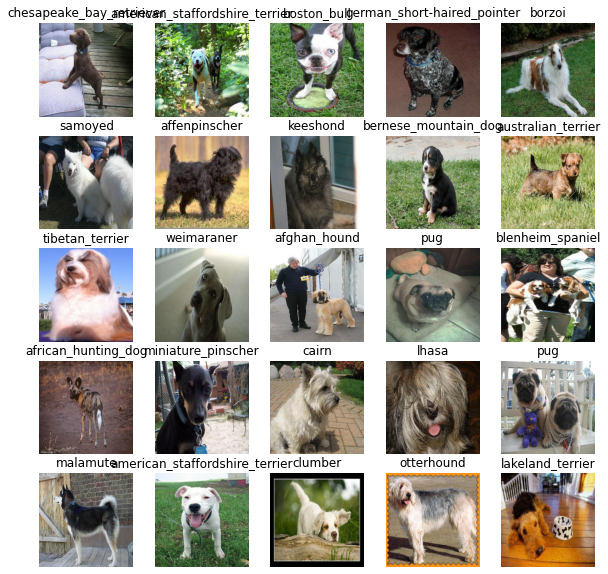

In [25]:
# Now let's visualize the data in a training batch
show_25_images(train_images, train_labels)

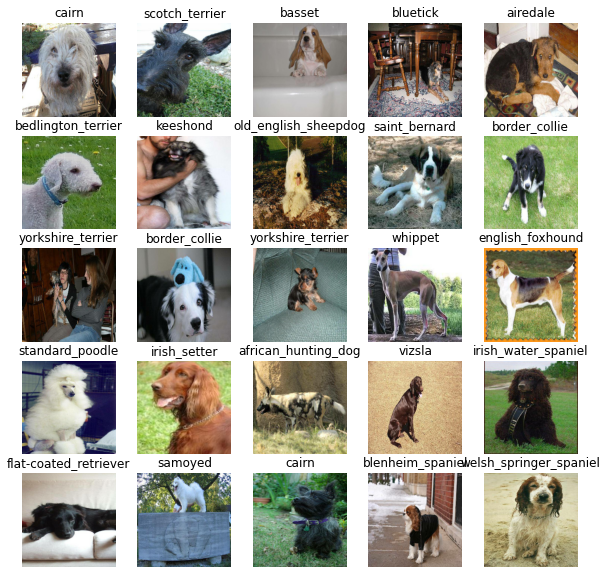

In [26]:
# Visualize validations set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Building a model

Before we build a model, there are a few things we need to define:
* The input shape (our images shape, in the form of Tensors) to our model.
* The output shape (image labels, in the form of Tensors) of our model.
* The URL of the model we want to use from TensorFlow Hub: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5

In [27]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, color channels

# Setup output shape of our model
OUTPUTH_SHAPE = len(unique_breed)

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

Let's put inputs, outputs and model into a Keras deep learning model

We need to create a function which:
* Takes the input shape, output shape and the model we have chosen as parameters.
* Defines the layers in a Keras model in sequential fashion.
* Compiles the model.
* Builds the model (tells the model the input shape it'll be getting).
* Returns the model.

All of these steps can be found here: https://www.tensorflow.org/guide/keras/sequential_model

In [28]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUTH_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
                               hub.KerasLayer(MODEL_URL), # Layers 1 (input layer)
                               tf.keras.layers.Dense(units=OUTPUTH_SHAPE,
                                                     activation='softmax') # Layer 2 (output layer)
  ])

  # Complie the model
  model.compile(
      loss = tf.keras.losses.CategoricalCrossentropy(),
      optimizer = tf.keras.optimizers.Adam(),
      metrics = ["accuracy"]
  )
  
  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [29]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              5432713   
_________________________________________________________________
dense (Dense)                (None, 120)               120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Create Callbacks

Callbacks are helper function a model can use during training to do such things as save progressm check its progress or stop training early if a model stops improving.

We'll create two callbacks, one for TensorBoard which helps track our model progress and another for early stopping which prevents our model from training too long.



### TensorBoard Callback

To setup a TensorBoard callback, we need to do 3 things:
1. Load the TensorBoard notebook extension
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's `fit()` function.
3. Visualize our models training logs with the `%tenorboard` magic function.

In [30]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [31]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing Tensorboard logs
  logdir = os.path.join("/content/drive/MyDrive/Dog Breed Identification/logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping Callback

Early stopping helps stop our model from overfitting if a certain evaluation metrics strop improving.


In [32]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

## Training a model (on subset of data)

Our first model is only going to train on 1000 images, to make sure everything is working.

In [33]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

Let's create a function which trains a model.

* Create a model using `create_model()`
* Setup a TensorBoard `callback using create_tensorboard_callback()`
* Call the `fit()` function on our model passing it the training data, validation data, number of epochs to train for(`NUM_EPOCHS`) and the callbacks we'd like to use
* Return the model

In [34]:
# Build a function to train and return a trained model

def train_model():
  '''
  Trains a given model and returns the trained version
  '''
  # Create a model
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  
  # Return the fittel model
  return model

In [35]:
# Fit the model to the data
#model = train_model()

## Saving and reloading a trained model

In [36]:
# Create a function to save a model
def save_model(model, suffix=None):
  '''
  Saves a given model in a models directory and appends a suffix.
  '''
  # Create a model directory pathname with current time
  modeldir = os.path.join("/content/drive/MyDrive/Dog Breed Identification/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [37]:
# Create a function to load a trained model
def load_model(model_path):
  '''
  Loads a saved model from a specified path
  '''
  print(f"Load model from {model_path}")
  model = tf.keras.models.load_model(model_path, custom_objects={"KerasLayer":hub.KerasLayer})

  return model

In [38]:
# Save our model trained on 1000 images
#save_model(model, suffix="1000-images-mobilenetv2-Adam")

In [39]:
# Load a trained model
model = load_model("/content/drive/MyDrive/Dog Breed Identification/models/20210427-152020-1000-images-mobilenetv2-Adam.h5")

Load model from /content/drive/MyDrive/Dog Breed Identification/models/20210427-152020-1000-images-mobilenetv2-Adam.h5


In [40]:
# Evaluate the loaded model
model.evaluate(val_data)

7/7 [==============================] - 55s 4s/step - loss: 1.2692 - accuracy: 0.6950


[1.2692221403121948, 0.6949999928474426]

## Checking the TensorBoard logs



In [41]:
#%tensorboard --logdir /content/drive/MyDrive/Dog\ Breed\ Identification/logs

## Making and evaluating prediction using a trained model

In [42]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1)
predictions

7/7 [==============================] - 1s 123ms/step


array([[4.4450816e-04, 1.3077057e-04, 8.6482964e-04, ..., 4.0389778e-04,
        1.3020031e-05, 2.3411610e-03],
       [5.2383076e-04, 7.0747879e-04, 6.8661831e-03, ..., 5.9201207e-04,
        1.0433457e-03, 1.3665606e-04],
       [1.2889763e-04, 1.1812305e-04, 1.0057508e-05, ..., 1.4803225e-04,
        2.5917130e-05, 2.2216466e-04],
       ...,
       [3.3075405e-06, 3.8241036e-05, 1.2574320e-04, ..., 1.0256387e-05,
        1.3982241e-04, 6.9341128e-05],
       [9.3910011e-04, 1.0540994e-03, 8.5868902e-05, ..., 9.5805933e-04,
        8.8359855e-05, 1.4325475e-02],
       [6.5885938e-04, 5.7754711e-05, 1.6999242e-03, ..., 1.1123646e-03,
        1.3198846e-03, 8.8041445e-05]], dtype=float32)

In [43]:
#predictions.shape

In [44]:
# First prediction
index = 0
print(predictions[index])
print(f"Max value (probability of prediction): {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted label: {unique_breed[np.argmax(predictions[index])]}")

[4.44508158e-04 1.30770568e-04 8.64829635e-04 7.64570286e-05
 6.20643201e-04 3.56929377e-05 3.52879912e-02 9.55288706e-04
 2.75725295e-04 1.15464005e-04 7.77127279e-04 4.43402707e-04
 3.66223685e-04 5.87086324e-05 4.21255390e-04 8.24807619e-04
 7.06753926e-05 8.80376920e-02 1.11266327e-05 1.87192400e-05
 3.39169754e-04 1.34079004e-04 2.48177494e-05 8.69911863e-04
 6.60218066e-05 1.27178457e-04 1.10071249e-01 1.82780524e-04
 7.86222704e-03 2.62769579e-04 1.91284649e-04 3.09828366e-03
 5.46299678e-04 4.20989345e-05 4.54325454e-05 3.41142267e-02
 1.99524561e-06 5.45206654e-04 7.87019308e-05 8.98057042e-05
 1.86710223e-03 2.74161739e-05 1.49588421e-04 9.30851602e-05
 6.49773428e-05 5.34715655e-04 2.79333781e-05 1.92788109e-04
 6.70857087e-04 1.15677773e-04 4.51909233e-04 5.85390080e-05
 6.75828604e-04 9.26959547e-06 6.82330981e-04 2.19163267e-04
 9.36834185e-05 2.68189353e-03 6.99505268e-04 1.84177130e-01
 2.58535874e-04 6.69240690e-05 1.12270098e-03 1.04895727e-04
 1.03702291e-03 2.092951

In [45]:
# Turn prediction probabilities into their respective label
def get_pred_label(prediction_probabilities):
  '''
  Turn an aray of prediction probabilities into a label.
  '''
  return unique_breed[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[0])
pred_label

'irish_wolfhound'

Now since out validation data is still in a batch dataset, we will have to unbatch if to make prediction on the validation images and then compare those predictions to the validation labels (truth labels).

In [46]:
# Create a function to unbatch a batched dataset
def unbatchify(data):
  '''
  Takes a batched dataset of (image, label) Tensors and returns separate arrays of images and labels.
  '''

  images = []
  labels = []

  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breed[np.argmax(label)])
  return images, labels

In [47]:
# Unbatchify the validation dataset
val_images, val_labels = unbatchify(val_data)

Now we have ways to get:
* Prediction labels
* Validation labels (truth)
* Validation images

Let's make some function to make these a bit more visual.

We'll create a function which:
* Takes an array of prediction probabilities, an array of truth labels and an array of images and integers.
* Convert the prediction probabilites to a predicted label.
* Plot the predicted label, its predicted probability, the truth label and the target image on a single plot.

In [48]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  '''
  View the prediction, ground_truth and image for sample n
  '''
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image & remore ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the color or the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  # Change plot title to be predicted, probability of prediction and truth label
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label),
                                    color = color)

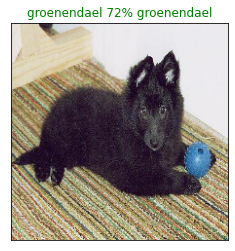

In [49]:
plot_pred(prediction_probabilities= predictions,
          labels = val_labels,
          images = val_images,
          n=77)

Let's make another function to view our models top 10 predictions

This function will:
* Take an input of prediction_probabilities array and a ground truth and an integer
* Find the prediction using `get_pred_label()`
* Find the top 10:
  * Prediction probabilities indexes
  * Prediction probabilities values
  * Prediction labels
* Plot the top 10 prediction probability values and labels, coloring the true label green 

In [50]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  '''
  Plots the top 10 highest prediction confidences along with the truth label for sample n.
  '''
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]

  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]

  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breed[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")
  
  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

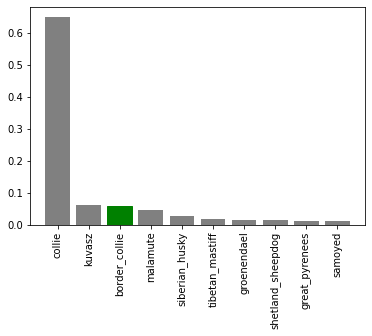

In [51]:
plot_pred_conf(prediction_probabilities= predictions,
               labels = val_labels,
               n=9)

Combine visualization function togheter

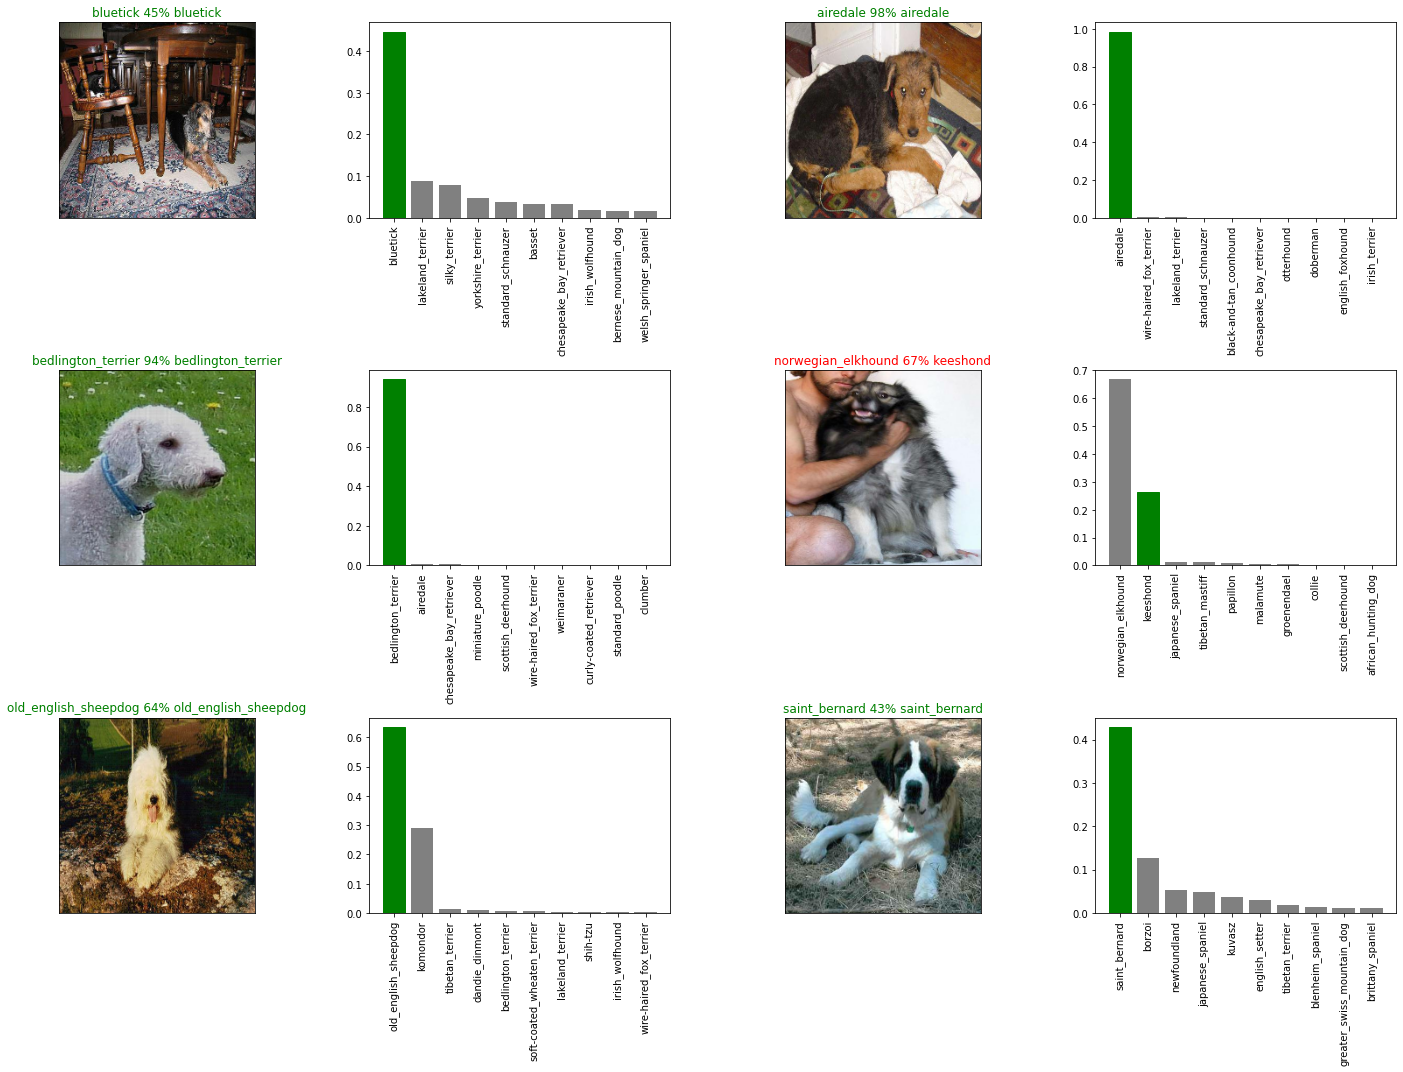

In [52]:
# # Let's check out a few predictions and their different values
i_multiplier = 3
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                 labels=val_labels,
                 n=i+i_multiplier)
plt.tight_layout()
plt.show()

## Training model on the full data

In [53]:
# Create a data batch with the full data set
full_data = create_data_batches(X,y)
full_data

Creating training data batches...


<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [54]:
# Create model
full_model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5


In [55]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()
# No validation set when training on all the data, so we can't monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

In [56]:
# Fit the full model to the full data
# full_model.fit(x=full_data,
#                epochs=NUM_EPOCHS,
#                callbacks=[full_model_tensorboard, full_model_early_stopping])

In [57]:
#save_model(full_model, suffix="full-image-set-mobilenetv2-Adam")

In [58]:
loaded_full_model = load_model("/content/drive/MyDrive/Dog Breed Identification/models/20210428-151621-full-image-set-mobilenetv2-Adam.h5")

Load model from /content/drive/MyDrive/Dog Breed Identification/models/20210428-151621-full-image-set-mobilenetv2-Adam.h5


## Making prediction on the test dataset

To make predictions on the test data:
* Get the test image filenames.
* Convert the filenames into test data batches using `create_data_batches()`. and setting the `test_data` parameter to `True` (test data does not have labels).
* Make a predictions array by passing the test batches to the `predict()` method called on our model.
* Save prediction in the format asked by kaggle: https://www.kaggle.com/c/dog-breed-identification/overview/evaluation



In [59]:
# Load test image filenames
test_path = "/content/drive/MyDrive/Dog Breed Identification/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['/content/drive/MyDrive/Dog Breed Identification/test/e7feb64da6aae1ef8e62453f6660d0c5.jpg',
 '/content/drive/MyDrive/Dog Breed Identification/test/e01b6b1e7cef1d9abdfbeb4afb88379f.jpg',
 '/content/drive/MyDrive/Dog Breed Identification/test/e13f3871a8b4a745717ba6903f0dfe05.jpg',
 '/content/drive/MyDrive/Dog Breed Identification/test/e5c0666aa15120eba4718ae947a52c45.jpg',
 '/content/drive/MyDrive/Dog Breed Identification/test/e334f758c7944df19c98d49498d28c64.jpg',
 '/content/drive/MyDrive/Dog Breed Identification/test/e726ac27864ecbde1f5822c4d6e26c17.jpg',
 '/content/drive/MyDrive/Dog Breed Identification/test/e12168553b1e0b5e56d5ab6ac8a58984.jpg',
 '/content/drive/MyDrive/Dog Breed Identification/test/e646ac89e0832502f9a726c72773cfcc.jpg',
 '/content/drive/MyDrive/Dog Breed Identification/test/e29f03a924c493b29d17877204dd0205.jpg',
 '/content/drive/MyDrive/Dog Breed Identification/test/e63a126acd70223f2d388702843d185b.jpg']

In [60]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)
test_data

Creating test data batches...


<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [61]:
# Make prediction on test data
# test_predictions = loaded_full_model.predict(test_data,
#                                              verbose=1)

In [62]:
# Save predictions to csv 
#np.savetxt("/content/drive/MyDrive/Dog Breed Identification/preds_array.csv", test_predictions, delimiter=",")

In [63]:
# Load predictions
loaded_pred = np.loadtxt("/content/drive/MyDrive/Dog Breed Identification/preds_array.csv", delimiter=',')

## Preparing test dataset predictions

Kaggle sample submission wants the models predictions probability outputs in a DataFrame with an ID and a column for each different dog breed.

* Create a pandas DF with and ID column as well as a column for each dog breed.
* Add data to teh ID column by extracting the test image ID's from their filepaths.
* Add data (the prediction probabilties) to each of the dog breed columns.
* Export DF as CSV.

In [71]:
# Create a pandas DF with empty column
preds_df = pd.DataFrame(columns=["id"] + list(unique_breed))

In [72]:
# Append test image ID's to prediction DF
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df['id'] = test_ids

In [75]:
# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breed)] = loaded_pred
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,e7feb64da6aae1ef8e62453f6660d0c5,3.07509e-07,8.28921e-06,3.4537e-09,8.35545e-08,2.98006e-07,4.33725e-07,5.84219e-07,1.08792e-07,8.76256e-09,6.50284e-08,1.54254e-09,1.88724e-05,8.69309e-07,0.00246711,2.37823e-07,9.7472e-08,3.54495e-07,1.75671e-09,7.34359e-08,1.60191e-08,2.85291e-07,1.89108e-06,2.27091e-06,8.16776e-06,3.01326e-06,5.16384e-06,2.34299e-09,1.07613e-08,2.35933e-08,0.000949288,0.77323,6.22034e-07,0.00145515,0.000446745,8.55245e-09,1.76996e-08,2.92498e-08,3.27439e-08,2.25636e-08,...,5.37467e-08,1.62422e-05,1.15809e-09,5.02086e-08,0.000305953,0.0361348,1.63519e-06,0.167887,7.74232e-07,7.80922e-07,5.94943e-08,3.33488e-07,9.0576e-07,9.23135e-07,3.79179e-05,7.00912e-08,5.29484e-10,2.70735e-09,3.92842e-07,7.05499e-05,1.20174e-07,8.72818e-07,7.82121e-09,5.06145e-07,1.36408e-05,2.02911e-06,6.21424e-09,1.41859e-05,0.000181882,3.15354e-07,0.00209543,4.75357e-08,1.46628e-06,1.88735e-08,6.60056e-08,2.26731e-08,6.32097e-10,1.3425e-08,4.02636e-07,0.000102598
1,e01b6b1e7cef1d9abdfbeb4afb88379f,9.57079e-10,2.91443e-09,4.92299e-10,8.8758e-11,9.20359e-10,2.17238e-13,0.935052,1.23282e-08,4.70434e-09,3.51735e-12,9.21125e-14,1.27128e-09,2.04864e-12,3.94051e-10,8.93643e-11,7.15834e-13,3.49061e-12,8.8352e-12,2.87565e-13,3.41119e-12,3.00553e-13,1.31996e-10,6.31145e-09,4.24587e-08,2.63126e-11,4.20651e-11,4.35229e-07,1.04122e-06,1.72761e-11,3.66625e-07,2.35588e-08,2.1002e-11,6.1073e-11,4.8109e-11,1.44861e-14,9.37975e-10,4.78293e-09,4.4502e-11,5.56512e-11,...,5.31396e-10,0.0648901,8.87316e-13,7.64775e-13,1.52739e-08,4.95711e-09,1.47916e-08,3.7728e-09,2.0969e-12,1.32324e-10,9.8609e-12,7.74644e-13,6.07002e-12,1.82829e-14,6.01537e-10,8.69931e-08,4.96161e-06,4.01402e-13,3.08156e-07,1.99426e-11,1.60983e-11,6.01399e-13,1.21169e-06,8.14952e-13,1.18562e-09,9.4185e-11,1.71104e-12,1.17924e-07,3.47879e-11,3.61272e-11,5.94758e-10,1.7528e-11,4.22421e-12,9.86775e-13,5.63597e-14,8.54202e-11,3.00599e-10,7.62559e-12,1.14506e-11,7.74761e-09
2,e13f3871a8b4a745717ba6903f0dfe05,1.3348e-10,7.75688e-07,2.33464e-08,1.46701e-07,1.20505e-05,5.98055e-10,2.71642e-07,3.9784e-11,1.19363e-07,2.55237e-09,8.66752e-10,8.88214e-11,2.81547e-08,1.02142e-09,0.00704879,0.000103701,1.61142e-07,7.06317e-07,3.67823e-08,1.37516e-11,6.32775e-09,3.34665e-10,1.26585e-11,7.1775e-14,2.3224e-07,2.27919e-05,5.58753e-11,3.99541e-09,0.12968,1.55572e-10,2.92402e-09,5.86824e-05,8.08586e-10,1.97118e-09,4.75276e-08,6.17536e-11,4.50644e-09,2.01145e-06,3.49721e-08,...,7.33832e-12,2.60606e-07,9.39653e-09,0.000211329,9.25146e-10,4.13703e-10,2.94555e-11,2.42126e-12,6.60962e-07,4.49067e-06,8.46699e-06,6.2358e-07,3.70383e-10,0.820556,4.67245e-13,2.56183e-11,2.01822e-11,5.02653e-08,7.69201e-09,8.10733e-11,3.74954e-08,1.97219e-11,2.38978e-11,9.73047e-08,1.61855e-09,1.64427e-09,1.36239e-07,2.34785e-08,2.02669e-07,5.0262e-11,9.0755e-11,6.59545e-13,1.46663e-09,3.08296e-06,8.8681e-05,4.28275e-10,8.69059e-12,3.97143e-05,5.

In [76]:
# Export to CSV
# preds_df.to_csv("/content/drive/MyDrive/Dog Breed Identification/full_model_predictions_submission_1_mobilenetV2.csv",
#                 index=False)

## Making predicitons on custom images

To make predictions on sutome images, we'll:
* Get the filepaths of our images.
* Turn th filepath into data batches using `create_data_batches()`. Our custom images do not have labels, so we set `test_data` parameter to `True`.
* Pass the custom image data batch to our model's `predict` method.
* Convert the prediction output probabilities to prediction labels.
* Compare the predicted labels to the custom images.

In [231]:
# Get custom image filepaths
custom_path = "/content/drive/MyDrive/Dog Breed Identification/custom_images/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [232]:
custom_image_paths

['/content/drive/MyDrive/Dog Breed Identification/custom_images/Pug-On-White-01.jpg',
 '/content/drive/MyDrive/Dog Breed Identification/custom_images/Cane-lupo-cecoslovacco-foto-razza-canina.jpg',
 '/content/drive/MyDrive/Dog Breed Identification/custom_images/tomm1.jpg',
 '/content/drive/MyDrive/Dog Breed Identification/custom_images/golden.jpg',
 '/content/drive/MyDrive/Dog Breed Identification/custom_images/dunno.jpg',
 '/content/drive/MyDrive/Dog Breed Identification/custom_images/tommy2.jpg',
 '/content/drive/MyDrive/Dog Breed Identification/custom_images/tommy3.jpg',
 '/content/drive/MyDrive/Dog Breed Identification/custom_images/tommy4.jpg']

In [233]:
# Turn custom images into data batches
custom_data = create_data_batches(custom_image_paths, test_data=True)
custom_data


Creating test data batches...


<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [234]:
# Make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)

In [235]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['pug',
 'siberian_husky',
 'airedale',
 'golden_retriever',
 'borzoi',
 'vizsla',
 'airedale',
 'airedale']

In [236]:
# Get custom images
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

In [237]:
def plot_custom_pred_conf(prediction_probabilities, image):
  '''
  Plots the top 5 highest prediction confidences along with the image
  '''
  pred_prob = prediction_probabilities

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 5 prediction confidence indexes
  top_5_pred_indexes = pred_prob.argsort()[-5:][::-1]

  # Find the top 5 prediction confidence values
  top_5_pred_values = pred_prob[top_5_pred_indexes]

  # Find the top 5 prediction labels
  top_5_pred_labels = unique_breed[top_5_pred_indexes]

  plt.figure(figsize=(10,10))

  # Predictions
  plt.subplot(1,2,1)
  top_plot = plt.barh(np.arange(len(top_5_pred_labels)),
                     top_5_pred_values,
                     color="grey")
  plt.yticks(np.arange(len(top_5_pred_labels)),
             labels=top_5_pred_labels)
  plt.tick_params(axis="y", labelsize=14)
  plt.gca().invert_yaxis()

  # Image
  plt.subplot(1,2,2)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(image)

  plt.tight_layout()

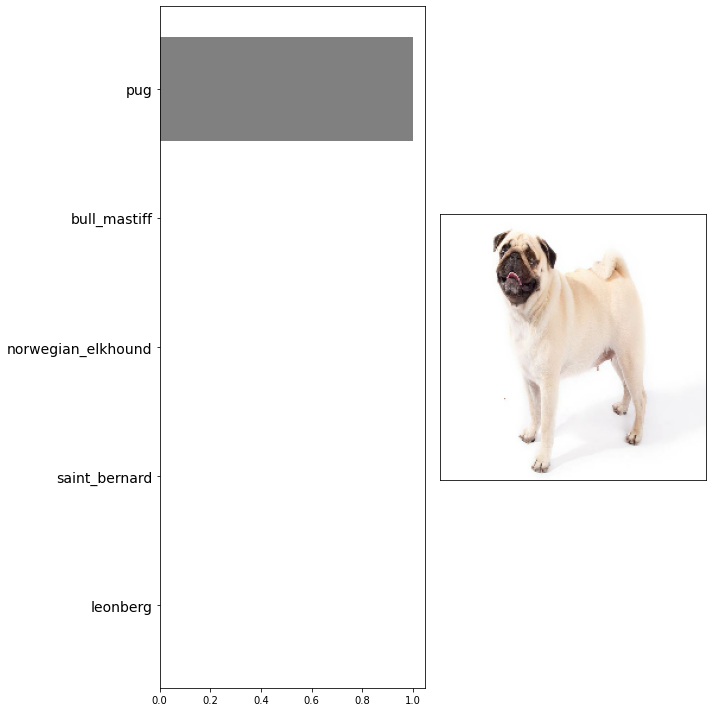

In [239]:
plot_custom_pred_conf(custom_preds[0], custom_images[0])

In [ ]:
o